#### Strongly based on colab notebook in the [github repo of Demucs](https://github.com/facebookresearch/denoiser)

In [1]:
from IPython import display as disp
import torch
import torchaudio
from denoiser import pretrained
from denoiser.dsp import convert_audio
import os
from glob import glob

In [2]:
model = pretrained.dns64().cuda()

In [3]:
print(model.sample_rate)  # desired sample rate of input waveform for the pretrained demucs model
print(model.chin)       # desried number of channels of input waveform for the pretrained demucs model

16000
1


In [4]:
DATA_DIR = "/home/ubuntu/efs/IntroDL/denoiser/dataset"
CLEAN_DIR = os.path.join(DATA_DIR, "starter_clean/clean")
NOISY_DIR = os.path.join(DATA_DIR, "starter_noisy/noisy")

In [5]:
clean_files = sorted(glob(CLEAN_DIR + "/*"))
noisy_files = sorted(glob(NOISY_DIR + "/*"))

`clean_files` and `noisy_files` does not have same order of files ; i.e. the i-th file of `clean_files` does not correspond to the i-th files of `noisy_files`. Hence, we should make the file id of the i-th file of `clean_files` and `noisy_files` correspond to each other. 

In [6]:
clean_dict = {os.path.basename(name).split('_')[-1]:name for name in clean_files}
noisy_dict = {os.path.basename(name).split('_')[-1]:name for name in noisy_files}


In [7]:
print(len(clean_files) == len(noisy_files))
print(set(clean_dict.keys()) == set(noisy_dict.keys()))
# Check that the set of file id of clean files and noisy files are exactly the same

True
True


In [8]:
clean_files = []
noisy_files = []
for fileid in clean_dict.keys() : 
    clean_files.append(clean_dict[fileid])
    noisy_files.append(noisy_dict[fileid])


In [9]:
clean_files[0]

'/home/ubuntu/efs/IntroDL/denoiser/dataset/starter_clean/clean/clean_fileid_0.wav'

In [10]:
noisy_files[0]

'/home/ubuntu/efs/IntroDL/denoiser/dataset/starter_noisy/noisy/clnsp126_3Wjw0nadnM4_snr15_tl-22_fileid_0.wav'

## Denoise one noisy file 

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [50]:
j = np.random.randint(len(noisy_files))
j

127

In [51]:
model = pretrained.dns64().cuda()
wav, sr = torchaudio.load(noisy_files[j])
wav = convert_audio(wav.cuda(), sr, model.sample_rate, model.chin)
with torch.no_grad():
    denoised = model(wav[None])[0]
disp.display(disp.Audio(wav.data.cpu().numpy(), rate=model.sample_rate))
disp.display(disp.Audio(denoised.data.cpu().numpy(), rate=model.sample_rate))

In [52]:
noisy_one = wav.cpu().numpy().reshape(-1)
denoised_one = denoised.cpu().numpy().reshape(-1)

In [54]:
np.mean(np.square(noisy_one - denoised_one))


0.0021288793

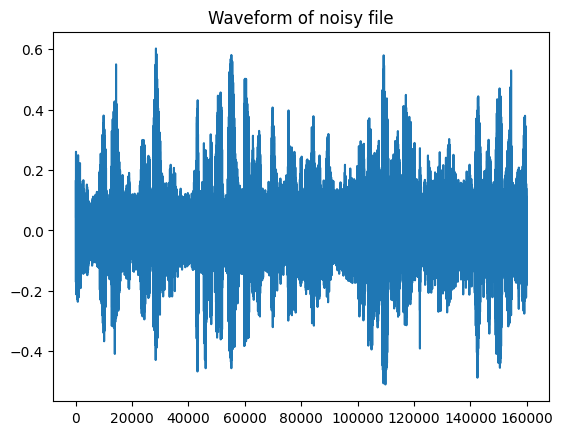

In [55]:
plt.plot(np.arange(len(noisy_one)),noisy_one)
plt.title("Waveform of noisy file")
plt.show()

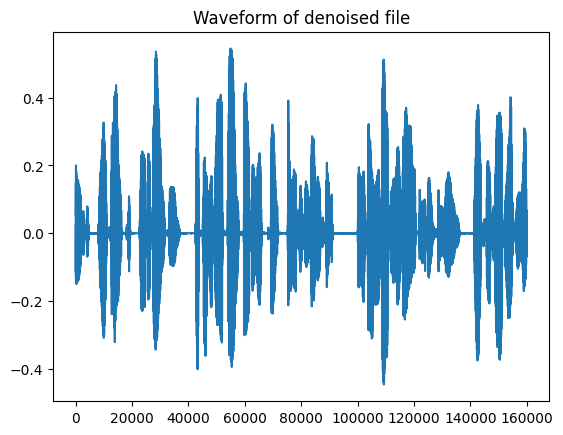

In [56]:
plt.plot(np.arange(len(denoised_one)),denoised_one)
plt.title("Waveform of denoised file")
plt.show()

In [57]:
noisy_files[0].split(sep = "/")[-1]

'clnsp126_3Wjw0nadnM4_snr15_tl-22_fileid_0.wav'

In [58]:
SAVE_DIR = "/home/ubuntu/efs/IntroDL/denoiser/results"
os.path.join(SAVE_DIR, "Demucs_denoised", noisy_files[j].split(sep= "/")[-1])


'/home/ubuntu/efs/IntroDL/denoiser/results/Demucs_denoised/clnsp200_TgjQN698XU8_snr4_tl-21_fileid_6.wav'

In [59]:
torchaudio.save(os.path.join(SAVE_DIR, "Demucs_denoised", noisy_files[j].split(sep= "/")[-1]), denoised.cpu(), model.sample_rate)

## Denoise all noisy files

In [95]:
len(noisy_files)

150

In [45]:
model = pretrained.dns64().cuda()
for i in range(len(noisy_files)) :
    print("{}-th file is being denoised...".format(i+1))
    wav, sr = torchaudio.load(noisy_files[i])
    wav = convert_audio(wav.cuda(), sr, model.sample_rate, model.chin)
    with torch.no_grad():
        denoised = model(wav[None])[0]
    # torchaudio.save(os.path.join(SAVE_DIR, "Demucs_denoised", noisy_files[i].split(sep= "/")[-1]), denoised.cpu(), model.sample_rate)
    torchaudio.save(os.path.join(SAVE_DIR, "Demucs_denoised", noisy_files[i].split(sep= "/")[-1]), torch.clamp(denoised.cpu(), -1, 1), model.sample_rate, precision = 32)
    del denoised, wav

1-th file is being denoised...
2-th file is being denoised...
3-th file is being denoised...
4-th file is being denoised...
5-th file is being denoised...
6-th file is being denoised...
7-th file is being denoised...
8-th file is being denoised...
9-th file is being denoised...
10-th file is being denoised...
11-th file is being denoised...
12-th file is being denoised...
13-th file is being denoised...
14-th file is being denoised...
15-th file is being denoised...
16-th file is being denoised...
17-th file is being denoised...
18-th file is being denoised...
19-th file is being denoised...
20-th file is being denoised...
21-th file is being denoised...
22-th file is being denoised...
23-th file is being denoised...
24-th file is being denoised...
25-th file is being denoised...
26-th file is being denoised...
27-th file is being denoised...
28-th file is being denoised...
29-th file is being denoised...
30-th file is being denoised...
31-th file is being denoised...
32-th file is bei

**Why does a simple `torchsave` triggers a problem**

For some file such as fileid 104 or 169, enhanced file resulted from Demucs pretrained model has some value bigger than 1 or smaller than -1. We should clamp it by -1 and 1. If not, the wave file resulted from `torchsave` yields zero tensor.

(Source : [github pytorch/audio issue : Saving and loading the downsampled audio results in a tensor with zeros.](https://github.com/pytorch/audio/issues/252))

In [60]:
i = 3

In [61]:
os.path.join(SAVE_DIR, "Demucs_denoised", noisy_files[i].split(sep= "/")[-1])

'/home/ubuntu/efs/IntroDL/denoiser/results/Demucs_denoised/clnsp228_vacuum_379760_1_snr1_tl-19_fileid_104.wav'

In [62]:
model = pretrained.dns64().cuda()
wav, sr = torchaudio.load(noisy_files[i])
wav = convert_audio(wav.cuda(), sr, model.sample_rate, model.chin)
with torch.no_grad():
    denoised = model(wav[None])[0]
disp.display(disp.Audio(wav.data.cpu().numpy(), rate=model.sample_rate))
disp.display(disp.Audio(denoised.data.cpu().numpy(), rate=model.sample_rate))



In [63]:
torchaudio.save('torchsave_test.wav', denoised.cpu(), model.sample_rate, precision = 32)

In [64]:
torchaudio.save('torchsave_test_clamp.wav', torch.clamp(denoised.cpu(), -1, 1), model.sample_rate, precision = 32)

In [65]:
torchaudio.load('torchsave_test.wav')

(tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), 16000)

In [66]:
torchaudio.load('torchsave_test_clamp.wav')

(tensor([[-0.0131, -0.0123, -0.0100,  ..., -0.0005, -0.0009, -0.0008]]), 16000)

In [71]:
print(any(denoised.data.cpu().reshape(-1) > 1))
print(any(denoised.data.cpu().reshape(-1) > 1.01))

True
False
